In [1]:
from discriminator.discriminator_wrapper import DiscriminatorWrapper
from coco_utils import load_coco_data_struct
import tensorflow as tf
import numpy as np

Using TensorFlow backend.


### Load data

In [2]:
attention_mode = True
if attention_mode:
    vocab_data, train_data, val_data = load_coco_data_struct(base_dir="datasets/self_process", 
                                                             source_image_features='block5_conv4_max_pooled',
                                                             is_caption_separated=True,
                                                             mock_val=True)
else:
    vocab_data, train_data, val_data = load_coco_data_struct()


Loaded vocab data.
Embedding <class 'numpy.ndarray'> (2593, 304) float64
Word to index <class 'dict'> 2593
Index to word <class 'list'> 2593

Loaded train data.
Captions <class 'numpy.ndarray'> (407521, 19) int64
Image indices <class 'numpy.ndarray'> (407521,) int64
Image features <class 'numpy.ndarray'> (82783, 7, 7, 512) float32
Image urls <class 'numpy.ndarray'> (82783,) <U71

Loaded val data.
Captions <class 'numpy.ndarray'> (1000, 19) int64
Image indices <class 'numpy.ndarray'> (1000,) int64
Image features <class 'numpy.ndarray'> (1000, 7, 7, 512) float32
Image urls <class 'numpy.ndarray'> (1000,) <U71


### Pretrain and save

In [3]:
iter_num = 1 # 350 iters should reach convergence
batch_size = 1
sess = tf.InteractiveSession()
disc = DiscriminatorWrapper(train_data, val_data, vocab_data)
tf.global_variables_initializer().run()
train_loss, val_loss = disc.pre_train(sess, iter_num=iter_num, batch_size=batch_size)
assert len(train_loss) == len(val_loss)
assert len(train_loss) == iter_num

iter 0, loss: 0.03497879579663277


In [4]:
model_name = "discriminator"
disc.save_model(sess, model_name=model_name)

### Assign rewards

Avg reward:  0.0595529


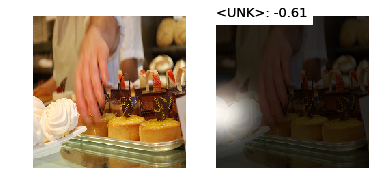

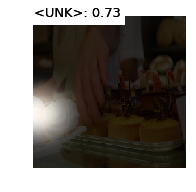

- - - -
Avg reward:  -0.193602


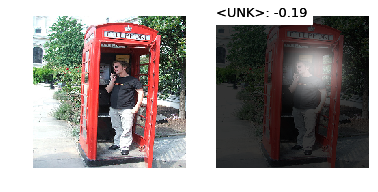

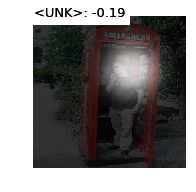

- - - -
Avg reward:  0.0659544


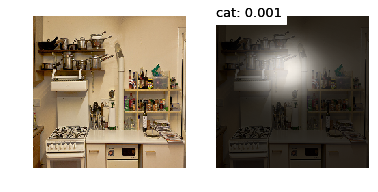

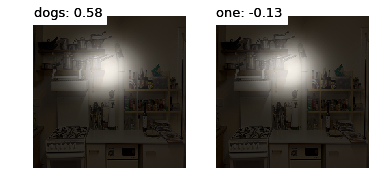

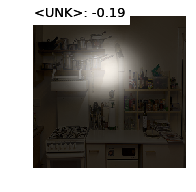

- - - -


In [5]:
train_image_idx = np.array([1, 2, 3])
captions = np.array(["haha hehe", "hello wordl", "cat dogs one helloo"])
_, rewards, _ = disc.assign_reward(sess, 
                                   train_image_idx, 
                                   captions,
                                   image_idx_from_training=True, 
                                   to_examine=True)
assert rewards.shape[0] == len(train_image_idx)
sess.close()

### Load Model

In [6]:
sess = tf.InteractiveSession()
loaded_disc = DiscriminatorWrapper(train_data, val_data, vocab_data,
                                   load_session=sess,
                                   saved_model_name=model_name)

INFO:tensorflow:Restoring parameters from models/discr/discriminator


In [7]:
_, rewards_after_loaded, _ = loaded_disc.assign_reward(sess, 
                                                       train_image_idx, 
                                                       captions,
                                                       image_idx_from_training=True, 
                                                       to_examine=False)

assert np.array_equal(rewards, rewards_after_loaded), "Loaded model should assign same rewards as trained model"

### Online train

In [8]:
online_all_loss, online_val_loss = loaded_disc.online_train(sess, iter_num=20, img_idxs=train_image_idx, caption_sentences=captions)

assert len(online_all_loss) == len(online_val_loss)

iter 0, loss: -0.02957531064748764
